In [135]:
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
from pyspark.sql.functions import col, udf, regexp_replace
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("FIFA").getOrCreate()

In [136]:
df = spark.read.csv('FIFA19.csv', header=True)

In [137]:
df = df.withColumn('ID', col('ID').cast('Integer')) \
       .withColumn('Name', col('Name').cast('String')) \
       .withColumn('Age', col('Age').cast('Integer')) \
       .withColumn('Nationality', col('Nationality').cast('String')) \
       .withColumn('Overall', col('Overall').cast('Integer')) \
       .withColumn('Potential', col('Potential').cast('Integer')) \
       .withColumn('Club', col('Club').cast('String')) \
       .withColumn('Value', col('Value').cast('String')) \
       .withColumn('Wage', col('Wage').cast('String')) \
       .withColumn('Preferred Foot', col('Preferred Foot').cast('String')) \
       .withColumn('Body Type', col('Body Type').cast('String')) \
       .withColumn('Position', col('Position').cast('String')) \
       .withColumn('Height', col('Height').cast('String')) \
       .withColumn('Weight', col('Weight').cast('String'))
       
df = df.select("ID",
               "Name", 
               "Age", 
               "Nationality",
               "Overall", 
               "Club",
               "Value", 
               "Wage",
               "Preferred Foot",
               "Weak Foot",
               "Body Type",
               "Position", 
               "Jersey Number", 
               "Joined",
               "Height", 
               "Weight",
               "Crossing", 
               "Finishing", 
               "HeadingAccuracy", 
               "ShortPassing", 
               "Volleys", 
               "Dribbling", 
               "Curve", 
               "FKAccuracy", 
               "LongPassing", 
               "BallControl", 
               "Acceleration", 
               "SprintSpeed", 
               "Agility", 
               "Reactions", 
               "Balance", 
               "ShotPower", 
               "Jumping", 
               "Stamina", 
               "Strength", 
               "LongShots", 
               "Aggression", 
               "Interceptions", 
               "Positioning", 
               "Vision", 
               "Penalties", 
               "Composure", 
               "Marking", 
               "StandingTackle", 
               "SlidingTackle", 
               "GKDiving", 
               "GKHandling", 
               "GKKicking", 
               "GKPositioning", 
               "GKReflexes", 
               "Release Clause")

In [138]:
def convert_money(Value):
    if Value is None:
        return None
    Value = Value.replace('€', '')
    if 'K' in Value:
        return int(float(Value.replace('K', '')) * 1000)
    elif 'M' in Value:
        return int(float(Value.replace('M', '')) * 1000000)
    else:
        return int(Value)

convert_money_udf = udf(convert_money, IntegerType())

def convert_height(height):
    if height is None:
        return None
    feet, inches = height.split("'")
    feet = int(feet)
    inches = int(inches.replace('"', ''))
    total_inches = feet * 12 + inches
    return round(total_inches * 2.54, 2) 

convert_height_udf = udf(convert_height, DoubleType())

In [139]:
Fifa_Data = df.withColumn('Value', convert_money_udf(col('Value'))) \
       .withColumn('Wage', convert_money_udf(col('Wage'))) \
       .withColumn('Weight', regexp_replace(col('Weight'), 'lbs', '')) \
       .withColumn('Height', convert_height_udf(col('Height'))) \
       .withColumn('Release Clause', convert_money_udf(col('Release Clause')))
df = Fifa_Data

In [140]:
df.write.mode('overwrite').format('parquet').saveAsTable('FIFA19_DATA')

Analysis

Ages vs Frequency

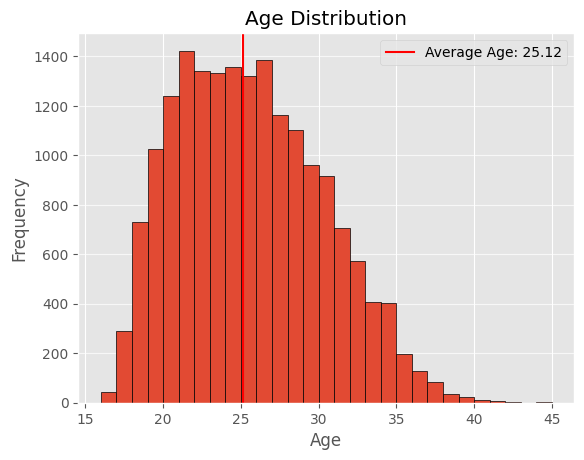

In [141]:
Ages = Fifa_Data.select('Age').rdd.flatMap(lambda x: x).collect()

plt.hist(Ages, bins=range(min(Ages), max(Ages) + 1, 1), edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-', alpha=0.7)
average = np.mean(Ages)
plt.axvline(x=average, color='red', linestyle='-', label=f'Average Age: {average:.2f}')
plt.legend()
plt.show()

Nationality vs Frequency

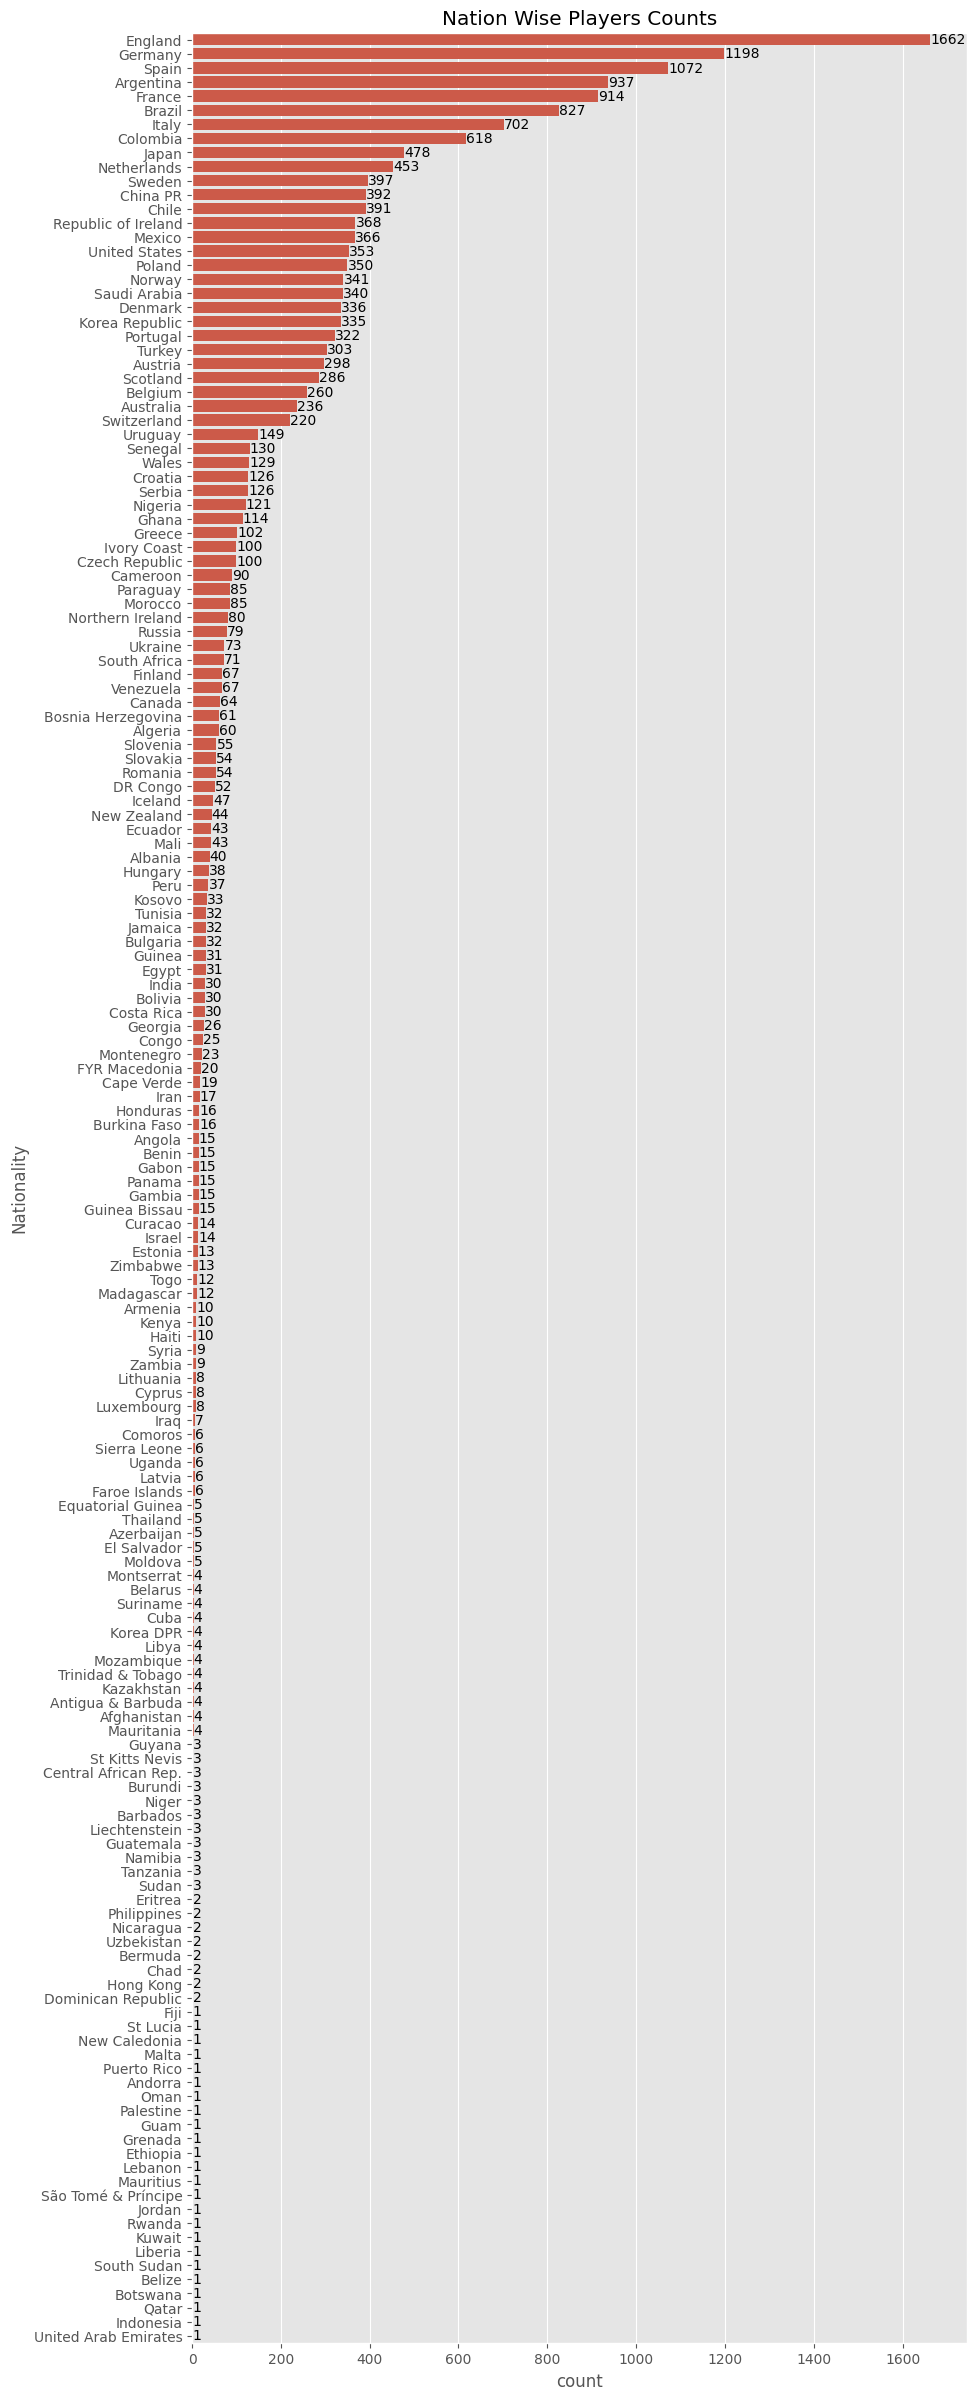

In [142]:
nationality_counts = Fifa_Data.groupBy('Nationality').count().orderBy('count', ascending=False)
nationality_counts_df = nationality_counts.toPandas()


plt.figure(figsize = (10, 30))
ax = sns.barplot(x = "count", y = "Nationality", data = nationality_counts_df)
for index, value in enumerate(nationality_counts_df['count']):
    ax.text(value, index, str(value), ha='left', va='center', fontsize=10)
plt.title("Nation Wise Players Counts");
plt.show()

Players vs Positions

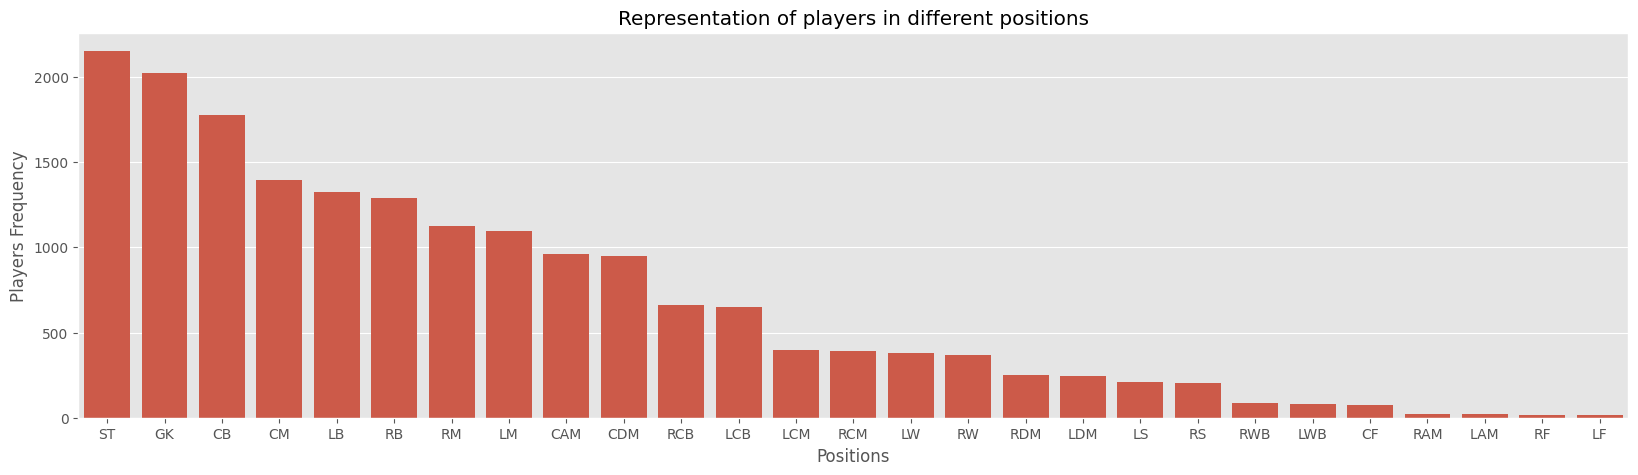

In [143]:
Position_counts = Fifa_Data.groupBy('Position').count().orderBy('count', ascending=False)
Position_counts_df = Position_counts.toPandas()

plt.figure(figsize=(20,5))
sns.barplot(x='Position',y='count', data=Position_counts_df)
plt.xlabel('Positions')
plt.ylabel('Players Frequency')
plt.title("Representation of players in different positions")
plt.show()

Prefered Foot of Players

/var/folders/ys/dxxwlhx16v3dl402b1gm7hrh0000gn/T/ipykernel_94040/2483462660.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Fifa_Data['Preferred Foot'], palette=color)


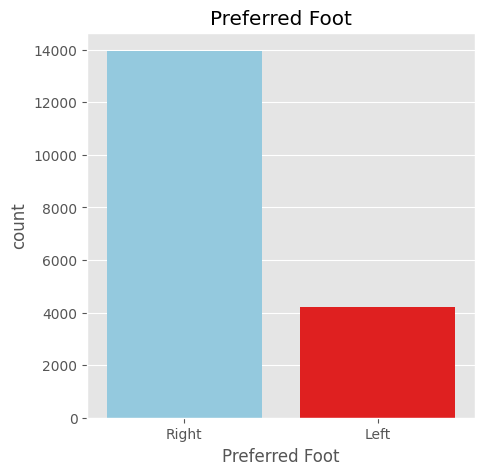

In [144]:
Fifa_Data = df.toPandas()

color = ["skyblue", "red"]
preferred_foot = Fifa_Data['Preferred Foot'].value_counts().reset_index()
preferred_foot.columns = ['Foot', "Total Players"]
preferred_foot = preferred_foot.set_index('Foot')

plt.figure(figsize = (5,5))
sns.countplot(x=Fifa_Data['Preferred Foot'], palette=color)
plt.title("Preferred Foot")
plt.show()

Players and Overall Rating

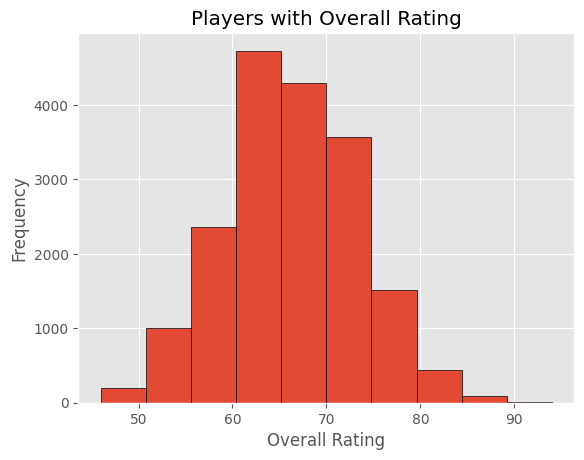

In [145]:
plt.title("Players with Overall Rating")
plt.hist(Fifa_Data["Overall"], edgecolor="black")
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.show()

Players with Max Stats

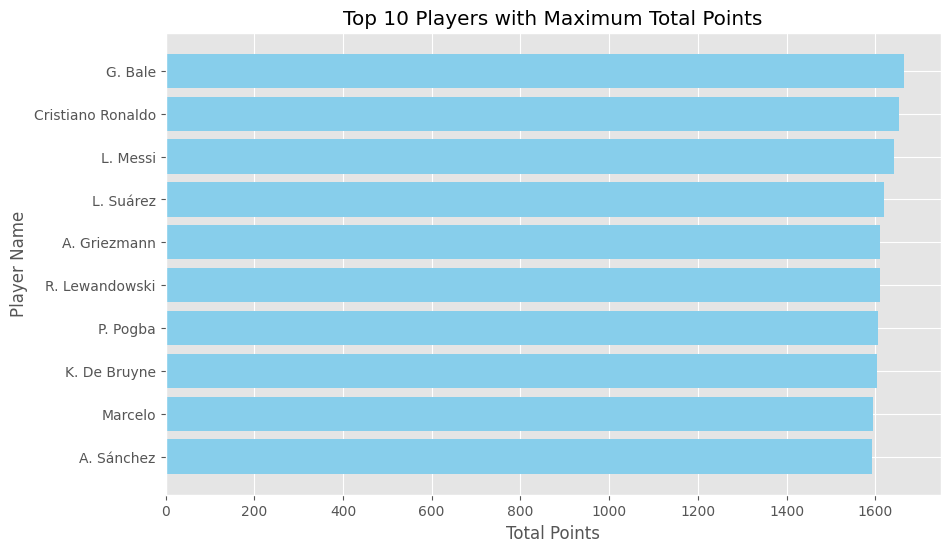

In [146]:
df = spark.sql("""
    SELECT 
        Name,
        (Finishing + HeadingAccuracy + ShortPassing + Volleys + Dribbling +
         Curve + FKAccuracy + LongPassing + BallControl + Acceleration +
         SprintSpeed + Agility + Reactions + Balance + ShotPower +
         Jumping + Strength + LongShots + Aggression + Interceptions) AS TotalPoints
    FROM FIFA19_DATA ORDER BY TotalPoints DESC
""")

top_players = df.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_players['Name'], top_players['TotalPoints'], color='skyblue')
plt.xlabel('Total Points')
plt.ylabel('Player Name')
plt.title('Top 10 Players with Maximum Total Points')
plt.gca().invert_yaxis() 
plt.show()

Clubs Vs Value

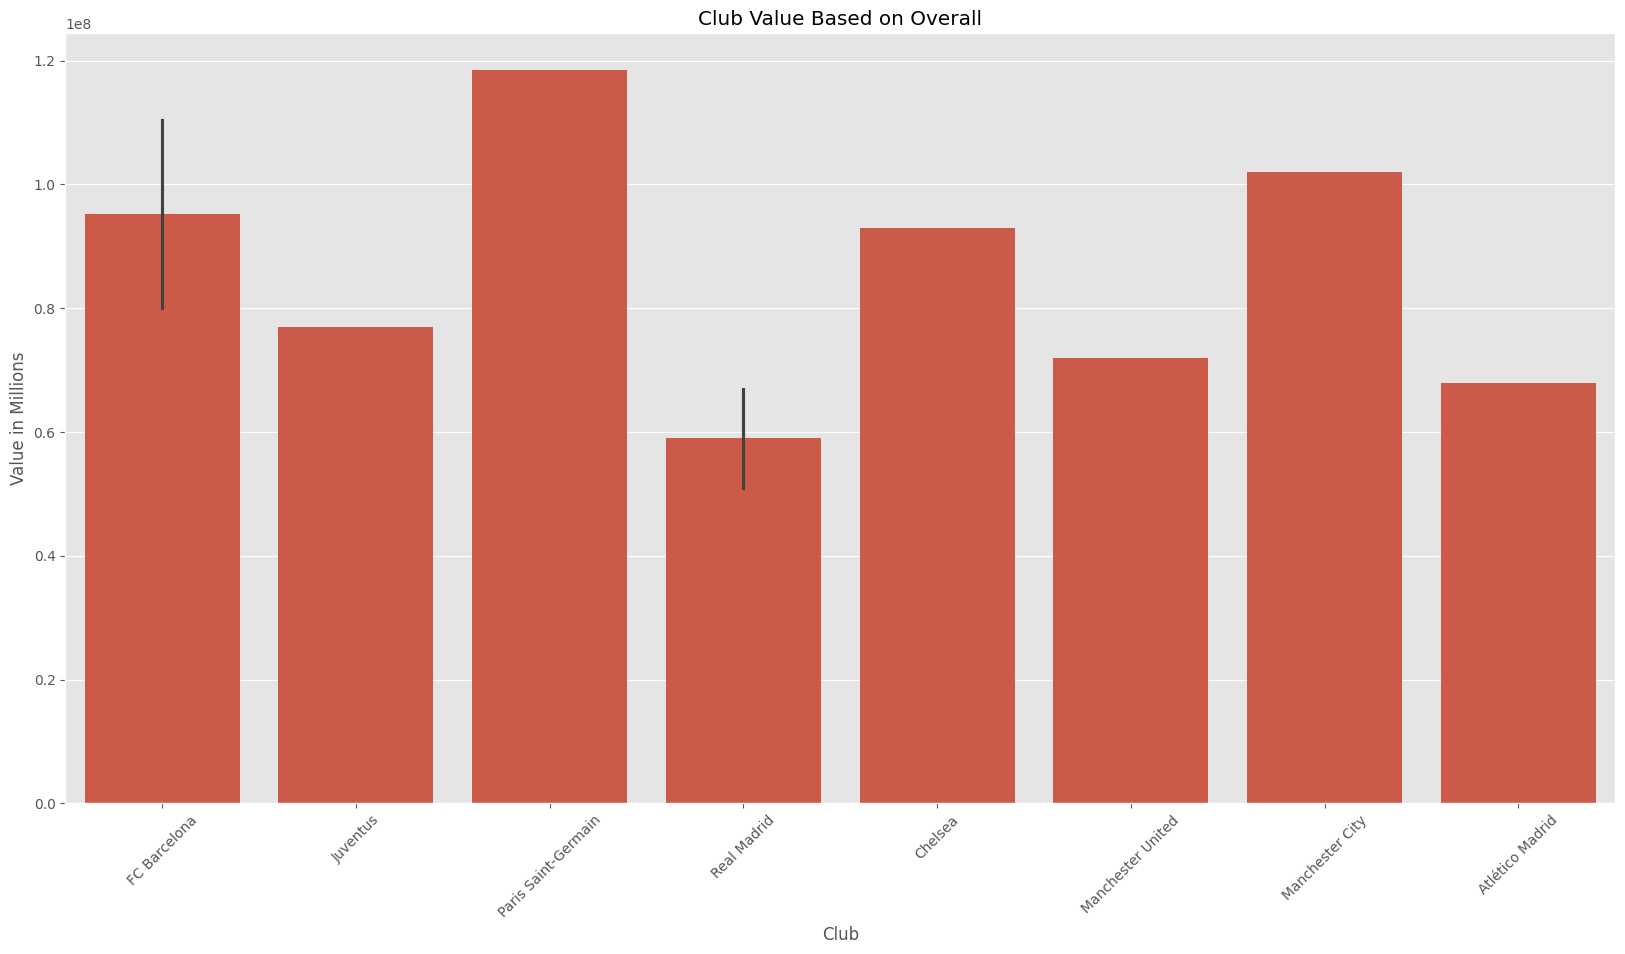

In [165]:
df = spark.sql(
    """SELECT Club, Value, Overall FROM FIFA19_DATA GROUP BY Overall, Club, Value ORDER BY Overall DESC"""
)
data = df.limit(10).toPandas()
plt.figure(figsize=(20,10))
sns.barplot(x='Club', y='Value', data=data )
plt.xticks(rotation=45)
plt.ylabel("Value in Millions")
plt.title('Club Value Based on Overall')
plt.show()